## Importing libraries

In [16]:
import pandas as pd
import gzip
import csv
import json
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy 
import dateutil
from IPython.core.display import display, HTML
import os

import pylab


#import pandas as pd
from IPython.display import display
#import numpy as np
#import matplotlib.pyplot as plt
from scipy import optimize

## Read CSV file

In [17]:
%%time
df = pd.read_csv('example_dataset.csv',sep=',\s+', delimiter=',', encoding="utf-8", skipinitialspace=True)

Wall time: 554 ms


In [18]:
# show all headers
df.columns

Index(['nm_bedrooms', 'ceiling_fan', 'clothes_dryer', 'clothes_washer',
       'cooking_range', 'cool_stpnt', 'cool_stpnt_ofst_mag',
       'cool_stpnt_ofst_prd', 'dish_washer', 'ducts', 'nm_floors',
       'foundation', 'garage', 'house_size', 'heating_fuel', 'heat_stpnt',
       'heat_stpnt_ofst_mag', 'heat_stpnt_ofst_prd', 'hot_water_distribution',
       'cool_efficiency', 'cool_type', 'heat_pump', 'heat_electricity',
       'heat_natural_gas', 'heat_propane', 'is_heat_pump', 'infiltration',
       'insulation_crawlspace', 'insulation_finished_basement',
       'insulation_finished_roof', 'insulation_interzonal_floor',
       'insulation_slab', 'insulation_unfinished_attic',
       'insulation_unfinished_basement', 'insulation_wall', 'lighting',
       'location', 'extra_refrigerator', 'freezer', 'gas_fireplace', 'hot_tub',
       'pool', 'well_pump', 'neighbors', 'orientation', 'plug_loads',
       'pool_heater', 'pool_pump', 'refrigerator', 'roof_material', 'vintage',
       'wat

## Select specific variables from data set

In [19]:

df = df[[ 'nm_bedrooms', 'house_size','ceiling_fan', 'clothes_dryer', 'clothes_washer',
         'cooking_range', 'cool_stpnt', 'cool_stpnt_ofst_mag',
        'cool_stpnt_ofst_prd', 'dish_washer', 'ducts', 'nm_floors',
         #'foundation', 'garage', 'house_size', 'heating_fuel', 'heat_stpnt',
         #'heat_stpnt_ofst_mag', 'heat_stpnt_ofst_prd', 'hot_water_distribution',
         #'cool_efficiency', 'cool_type', 'heat_pump', 'heat_electricity',
         #'heat_natural_gas', 'heat_propane', 'is_heat_pump', 'infiltration', 
         #'lighting','location', 'extra_refrigerator', 'freezer', 'gas_fireplace', 'hot_tub',
         #'pool','well_pump', 'neighbors',
         #'pool_heater', 'pool_pump', 'refrigerator', 'roof_material', 'vintage',
         #'water_heater', 'windows',
         'total_site_energy' ]]

df.head(5)

,nm_bedrooms,house_size,ceiling_fan,clothes_dryer,clothes_washer,cooking_range,cool_stpnt,cool_stpnt_ofst_mag,cool_stpnt_ofst_prd,dish_washer,ducts,nm_floors,total_site_energy
0,2.0,1500-2499_LA,"1 Fan, 120% Usage","Gas, 120% Usage","EnergyStar, 120% Usage","Gas, 120% Usage",85F Variable Schedule,0F,None,"290 Rated kWh, 120% Usage","10% Leakage, R-4",1.0,48.623018
1,3.0,0-1499_LA,"1 Fan, 100% Usage","Gas, 100% Usage","EnergyStar, 100% Usage","Gas, 100% Usage",85F Variable Schedule,0F,None,"290 Rated kWh, 100% Usage","20% Leakage, R-4",1.0,38.585635
2,2.0,0-1499_LA,"2 Fans, 120% Usage","Gas, 120% Usage","EnergyStar, 120% Usage","Gas, 120% Usage",72F Variable Schedule,13F,"Morning, Day, Evening",None,"20% Leakage, R-4",1.0,29.628763
3,3.0,0-1499_LA,"1 Fan, 80% Usage",None,None,"Gas, 80% Usage",72F Variable Schedule,13F,"Morning, Night",None,"30% Leakage, Uninsulated",1.0,35.808531
4,3.0,1500-2499_LA,"3 Fans, 120% Usage","Gas, 120% Usage","EnergyStar, 120% Usage","Gas, 120% Usage",72F Variable Schedule,13F,"Morning, Day","290 Rated kWh, 120% Usage","20% Leakage, Uninsulated",2.0,70.214292


## Method to update distriubtion based on new mean and variance

In [20]:

def newWeightOptimization(oldWeights,vals,newMean,numberOfMoments):
    #recommended Number of moments = len(oldWeights)
    numberOfMoments = len(oldWeights)
    oldMean = 0
    for i in range(len(oldWeights)):
        oldMean += oldWeights[i]*vals[i]
    
    #calculate moments:
    moments = np.zeros(numberOfMoments)
    for i in range(numberOfMoments):
        for j in range(len(oldWeights)):
            moments[i]+=oldWeights[j]*((vals[j]-oldMean)**(i+2))
    
    bounds = []
    for i in range(len(oldWeights)):
        bounds.append((0,1))
    bounds = tuple(bounds)
    
    constraints = [{'type':'eq', 'fun':lambda x:np.sum(x)-1},{'type':'eq','fun':lambda x: np.dot(x,vals)-newMean}]
    
    def _func(x):
        
        Xmatrix = np.zeros((numberOfMoments,len(oldWeights)))

        for i in range(numberOfMoments):
            for j in range(len(oldWeights)):
                Xmatrix[i,j] = (vals[j]-newMean)**(i+2)
                
        Xmatrix /= np.linalg.norm(Xmatrix)
        #Xmatrix*=100
        objective = 0
        for i in range(numberOfMoments):
            objective += ((.5)*i)*(Xmatrix[i,:].dot(x))**2
        
        #optional regularization:
        
#         for i in range(len(x)):
#             objective += newMean*x[i]*np.log(x[i])
            
        return objective
    x0 = np.random.rand(len(oldWeights))
    x0/=sum(x0)
    res = optimize.minimize(_func,x0,bounds=bounds,constraints=constraints)
    
    return res.x
                


def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))


## 1- Adding sample distribution columns to dataset

In [21]:
%%time

# get lenght of dataframe
N = float(len(df))

# get distributions 
for c in df.columns:  
        if c == 'total_site_energy' or c == 'weight':
            continue
        print(f"Processing {c}")
        counts = df[c].value_counts()
        
        # find distributions and add distribution columns to dataframe
        df[c+'_dist'] = df[c].map(lambda x: counts.loc[x]) / N


Processing nm_bedrooms
Processing house_size
Processing ceiling_fan
Processing clothes_dryer
Processing clothes_washer
Processing cooking_range
Processing cool_stpnt
Processing cool_stpnt_ofst_mag
Processing cool_stpnt_ofst_prd
Processing dish_washer
Processing ducts
Processing nm_floors
Wall time: 10.3 s


In [22]:
# resulting dataframe
df.head()

,nm_bedrooms,house_size,ceiling_fan,clothes_dryer,clothes_washer,cooking_range,cool_stpnt,cool_stpnt_ofst_mag,cool_stpnt_ofst_prd,dish_washer,ducts,nm_floors,total_site_energy,nm_bedrooms_dist,house_size_dist,ceiling_fan_dist,clothes_dryer_dist,clothes_washer_dist,cooking_range_dist,cool_stpnt_dist,cool_stpnt_ofst_mag_dist,cool_stpnt_ofst_prd_dist,dish_washer_dist,ducts_dist,nm_floors_dist
0,2.0,1500-2499_LA,"1 Fan, 120% Usage","Gas, 120% Usage","EnergyStar, 120% Usage","Gas, 120% Usage",85F Variable Schedule,0F,None,"290 Rated kWh, 120% Usage","10% Leakage, R-4",1.0,48.623018,0.618445,0.351943,0.050718,0.184454,0.155812,0.207412,0.091214,0.278091,0.278091,0.096325,0.171499,0.696351
1,3.0,0-1499_LA,"1 Fan, 100% Usage","Gas, 100% Usage","EnergyStar, 100% Usage","Gas, 100% Usage",85F Variable Schedule,0F,None,"290 Rated kWh, 100% Usage","20% Leakage, R-4",1.0,38.585635,0.255266,0.491407,0.101216,0.368159,0.310963,0.412047,0.091214,0.278091,0.278091,0.192253,0.309950,0.696351
2,2.0,0-1499_LA,"2 Fans, 120% Usage","Gas, 120% Usage","EnergyStar, 120% Usage","Gas, 120% Usage",72F Variable Schedule,13F,"Morning, Day, Evening",None,"20% Leakage, R-4",1.0,29.628763,0.618445,0.491407,0.031815,0.184454,0.155812,0.207412,0.565260,0.424077,0.077113,0.397594,0.309950,0.696351
3,3.0,0-1499_LA,"1 Fan, 80% Usage",None,None,"Gas, 80% Usage",72F Variable Schedule,13F,"Morning, Night",None,"30% Leakage, Uninsulated",1.0,35.808531,0.255266,0.491407,0.051071,0.081960,0.040451,0.208117,0.565260,0.424077,0.156605,0.397594,0.076055,0.696351
4,3.0,1500-2499_LA,"3 Fans, 120% Usage","Gas, 120% Usage","EnergyStar, 120% Usage","Gas, 120% Usage",72F Variable Schedule,13F,"Morning, Day","290 Rated kWh, 120% Usage","20% Leakage, Uninsulated",2.0,70.214292,0.255266,0.351943,0.044461,0.184454,0.155812,0.207412,0.565260,0.424077,0.065700,0.096325,0.132238,0.272627


# 2- Adding target distributions to data set

In [23]:
# decide what variable you want to change ( ex. set a new target distribution for number of bedrooms)
# find what is the mean of this variable and what would be your target mean
df.nm_bedrooms.mean()

2.3933198202167976

In [24]:
%%time
# generate target distributions
for c in df.columns:  
    
        if '_dist' not in c and '_target' not in c and 'site_energy' not in c and 'weight' not in c:
            
            print(f"*************Processing {c}**************")
            # zip variables and distributions
            z = dict(zip(df[c],df[c+'_dist']))
            print (f"old_dist = {z}")

            ### set inputs to weightConverion method
            #set vals
            vals = np.array(list(z.keys()))
            #set oldDist
            oldDist = np.array(list(z.values()))
            #set targeted means of each variable distribution that is going to change
            if c == 'nm_bedrooms':
                newMean = 4
            #for non changing variables the target distribution will be same as the original distribution
            else: 
                print (f"new_dist = {z}")
                df[c+'_target'] = df[c+'_dist']
                continue
                
            numberOfMoments = 4

            # find target distributions(weights) for each variable that have a new target mean
            w = newWeightOptimization(oldDist,vals,newMean,numberOfMoments)
            # output new distributions as a list
            w = w.tolist()
            
            #zip weight and values
            new_dist = dict(zip(vals,w))
            print(f"new_dist = {new_dist}")

            # layout target distribution in data frame
            y=[]
            for x in df[c]:
                y.append(new_dist[x])

            df[c+'_target'] = y

*************Processing nm_bedrooms**************
old_dist = {2.0: 0.6184454040715608, 3.0: 0.255265708997973, 1.0: 0.04498986516259804, 5.0: 0.012646514497223937, 4.0: 0.0651714109456244, 6.0: 0.0026438706265973387, 7.0: 0.0008372256984224906}
new_dist = {2.0: 0.07349609150142536, 3.0: 0.22922322721416025, 1.0: 0.0, 5.0: 0.37621541021701, 4.0: 0.3210652710674044, 6.0: 1.3877787807814457e-17, 7.0: 0.0}
*************Processing house_size**************
old_dist = {'1500-2499_LA': 0.35194324491054907, '0-1499_LA': 0.4914074204635587, '3500+_LA': 0.053979025293029, '2500-3499_LA': 0.10267030933286331}
new_dist = {'1500-2499_LA': 0.35194324491054907, '0-1499_LA': 0.4914074204635587, '3500+_LA': 0.053979025293029, '2500-3499_LA': 0.10267030933286331}
*************Processing ceiling_fan**************
old_dist = {'1 Fan, 120% Usage': 0.05071825152022561, '1 Fan, 100% Usage': 0.10121618048823477, '2 Fans, 120% Usage': 0.03181457654005464, '1 Fan, 80% Usage': 0.051070767603771924, '3 Fans, 120% 

In [25]:
#resulting dataframe
pd.set_option('display.max_columns', 100)
df.head()

,nm_bedrooms,house_size,ceiling_fan,clothes_dryer,clothes_washer,cooking_range,cool_stpnt,cool_stpnt_ofst_mag,cool_stpnt_ofst_prd,dish_washer,ducts,nm_floors,total_site_energy,nm_bedrooms_dist,house_size_dist,ceiling_fan_dist,clothes_dryer_dist,clothes_washer_dist,cooking_range_dist,cool_stpnt_dist,cool_stpnt_ofst_mag_dist,cool_stpnt_ofst_prd_dist,dish_washer_dist,ducts_dist,nm_floors_dist,nm_bedrooms_target,house_size_target,ceiling_fan_target,clothes_dryer_target,clothes_washer_target,cooking_range_target,cool_stpnt_target,cool_stpnt_ofst_mag_target,cool_stpnt_ofst_prd_target,dish_washer_target,ducts_target,nm_floors_target
0,2.0,1500-2499_LA,"1 Fan, 120% Usage","Gas, 120% Usage","EnergyStar, 120% Usage","Gas, 120% Usage",85F Variable Schedule,0F,None,"290 Rated kWh, 120% Usage","10% Leakage, R-4",1.0,48.623018,0.618445,0.351943,0.050718,0.184454,0.155812,0.207412,0.091214,0.278091,0.278091,0.096325,0.171499,0.696351,0.073496,0.351943,0.050718,0.184454,0.155812,0.207412,0.091214,0.278091,0.278091,0.096325,0.171499,0.696351
1,3.0,0-1499_LA,"1 Fan, 100% Usage","Gas, 100% Usage","EnergyStar, 100% Usage","Gas, 100% Usage",85F Variable Schedule,0F,None,"290 Rated kWh, 100% Usage","20% Leakage, R-4",1.0,38.585635,0.255266,0.491407,0.101216,0.368159,0.310963,0.412047,0.091214,0.278091,0.278091,0.192253,0.309950,0.696351,0.229223,0.491407,0.101216,0.368159,0.310963,0.412047,0.091214,0.278091,0.278091,0.192253,0.309950,0.696351
2,2.0,0-1499_LA,"2 Fans, 120% Usage","Gas, 120% Usage","EnergyStar, 120% Usage","Gas, 120% Usage",72F Variable Schedule,13F,"Morning, Day, Evening",None,"20% Leakage, R-4",1.0,29.628763,0.618445,0.491407,0.031815,0.184454,0.155812,0.207412,0.565260,0.424077,0.077113,0.397594,0.309950,0.696351,0.073496,0.491407,0.031815,0.184454,0.155812,0.207412,0.565260,0.424077,0.077113,0.397594,0.309950,0.696351
3,3.0,0-1499_LA,"1 Fan, 80% Usage",None,None,"Gas, 80% Usage",72F Variable Schedule,13F,"Morning, Night",None,"30% Leakage, Uninsulated",1.0,35.808531,0.255266,0.491407,0.051071,0.081960,0.040451,0.208117,0.565260,0.424077,0.156605,0.397594,0.076055,0.696351,0.229223,0.491407,0.051071,0.081960,0.040451,0.208117,0.565260,0.424077,0.156605,0.397594,0.076055,0.696351
4,3.0,1500-2499_LA,"3 Fans, 120% Usage","Gas, 120% Usage","EnergyStar, 120% Usage","Gas, 120% Usage",72F Variable Schedule,13F,"Morning, Day","290 Rated kWh, 120% Usage","20% Leakage, Uninsulated",2.0,70.214292,0.255266,0.351943,0.044461,0.184454,0.155812,0.207412,0.565260,0.424077,0.065700,0.096325,0.132238,0.272627,0.229223,0.351943,0.044461,0.184454,0.155812,0.207412,0.565260,0.424077,0.065700,0.096325,0.132238,0.272627


## 3- Applying weighting method

In [26]:
%%time
#add Weight column to data frame (note that this weight column is for the whole dataframe and not for each column)
# the all the Weights are intialized to be 1 as a start
df["weight"] = 1 

# Set Solving tolerance
tol=1e-5

# Initialize delta weight
delta_w_norm = 1.0/tol


Wall time: 998 µs


In [27]:
#resulting dataframe
df.head()

,nm_bedrooms,house_size,ceiling_fan,clothes_dryer,clothes_washer,cooking_range,cool_stpnt,cool_stpnt_ofst_mag,cool_stpnt_ofst_prd,dish_washer,ducts,nm_floors,total_site_energy,nm_bedrooms_dist,house_size_dist,ceiling_fan_dist,clothes_dryer_dist,clothes_washer_dist,cooking_range_dist,cool_stpnt_dist,cool_stpnt_ofst_mag_dist,cool_stpnt_ofst_prd_dist,dish_washer_dist,ducts_dist,nm_floors_dist,nm_bedrooms_target,house_size_target,ceiling_fan_target,clothes_dryer_target,clothes_washer_target,cooking_range_target,cool_stpnt_target,cool_stpnt_ofst_mag_target,cool_stpnt_ofst_prd_target,dish_washer_target,ducts_target,nm_floors_target,weight
0,2.0,1500-2499_LA,"1 Fan, 120% Usage","Gas, 120% Usage","EnergyStar, 120% Usage","Gas, 120% Usage",85F Variable Schedule,0F,None,"290 Rated kWh, 120% Usage","10% Leakage, R-4",1.0,48.623018,0.618445,0.351943,0.050718,0.184454,0.155812,0.207412,0.091214,0.278091,0.278091,0.096325,0.171499,0.696351,0.073496,0.351943,0.050718,0.184454,0.155812,0.207412,0.091214,0.278091,0.278091,0.096325,0.171499,0.696351,1
1,3.0,0-1499_LA,"1 Fan, 100% Usage","Gas, 100% Usage","EnergyStar, 100% Usage","Gas, 100% Usage",85F Variable Schedule,0F,None,"290 Rated kWh, 100% Usage","20% Leakage, R-4",1.0,38.585635,0.255266,0.491407,0.101216,0.368159,0.310963,0.412047,0.091214,0.278091,0.278091,0.192253,0.309950,0.696351,0.229223,0.491407,0.101216,0.368159,0.310963,0.412047,0.091214,0.278091,0.278091,0.192253,0.309950,0.696351,1
2,2.0,0-1499_LA,"2 Fans, 120% Usage","Gas, 120% Usage","EnergyStar, 120% Usage","Gas, 120% Usage",72F Variable Schedule,13F,"Morning, Day, Evening",None,"20% Leakage, R-4",1.0,29.628763,0.618445,0.491407,0.031815,0.184454,0.155812,0.207412,0.565260,0.424077,0.077113,0.397594,0.309950,0.696351,0.073496,0.491407,0.031815,0.184454,0.155812,0.207412,0.565260,0.424077,0.077113,0.397594,0.309950,0.696351,1
3,3.0,0-1499_LA,"1 Fan, 80% Usage",None,None,"Gas, 80% Usage",72F Variable Schedule,13F,"Morning, Night",None,"30% Leakage, Uninsulated",1.0,35.808531,0.255266,0.491407,0.051071,0.081960,0.040451,0.208117,0.565260,0.424077,0.156605,0.397594,0.076055,0.696351,0.229223,0.491407,0.051071,0.081960,0.040451,0.208117,0.565260,0.424077,0.156605,0.397594,0.076055,0.696351,1
4,3.0,1500-2499_LA,"3 Fans, 120% Usage","Gas, 120% Usage","EnergyStar, 120% Usage","Gas, 120% Usage",72F Variable Schedule,13F,"Morning, Day","290 Rated kWh, 120% Usage","20% Leakage, Uninsulated",2.0,70.214292,0.255266,0.351943,0.044461,0.184454,0.155812,0.207412,0.565260,0.424077,0.065700,0.096325,0.132238,0.272627,0.229223,0.351943,0.044461,0.184454,0.155812,0.207412,0.565260,0.424077,0.065700,0.096325,0.132238,0.272627,1


### running weighting method

MAX DELTA_W ==== 0.016188412824030114
MAX DELTA_W ==== 0.01613966750317997
MAX DELTA_W ==== 0.0
Wall time: 5.07 s


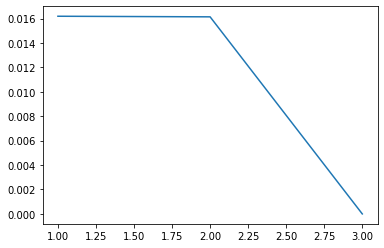

In [28]:
%%time
# initialize number of itterations
count = 0
itterations = []
# initialize delta_w list 
delta_w_list = []

#initilize total weight
tW = df.weight.sum()

# while the normalize delta weigth (average) is less than the tolerance
while delta_w_norm > tol:
    
    # get w_old
    w_old = df['weight']  
    
    # add number of itterations to a list
    count += 1
    itterations.append(count)
    
    for c in df.columns:     

        if 'total_site_energy' not in c and 'weight' not in c and '_dist' not in c and '_target' not in c and '_weight' not in c:

            #print (f"********processing {c}*********")
            #w_old = df['weight']
            #print (f"w_old = {w_old.head()}")
    
    
            #change original distributions
            a = df[[c , 'weight']].groupby(c, as_index = False ).sum()
            dict_a = dict(zip(a[c], a['weight']))          
            df[c+'_dist'] = df[c].map(lambda x: dict_a[x]/tW)

            # find weights for each variable
            df[c+'_weight'] = df[c+'_target'] / df[c+'_dist']                     

            # multiple by main weight column
            df['weight'] =  df['weight'] * df[c+'_weight']

    # find new weight w_new
    w_new = df['weight']
    #print (f"w_new = {w_new.head()}")
    
    # find delta weight
    delta_w = np.abs(w_old - w_new)
    
    delta_w_norm = np.sqrt(np.sum(np.power(delta_w,2.0)))/float(len(delta_w))
    #print ("*****************************************************************")
    print(f"MAX DELTA_W ==== {delta_w_norm}")
    #print ("*****************************************************************")

    # put delta_w in a list 
    delta_w_list.append(delta_w_norm)

plt.plot(itterations, delta_w_list)

# Visualize results

In [14]:
len(itterations)

0

In [168]:
len(delta_w_list)

3

In [97]:
del itterations[-1]

In [37]:
#len(itterations)

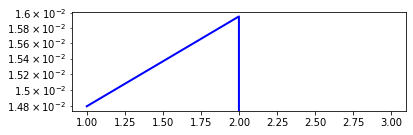

In [198]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

ax.plot(itterations, delta_w_list, color='blue', lw=2)

ax.set_yscale('log')

pylab.show()

In [495]:
print(delta_w_list)
print(itterations)

[nan]
[1]
